---
> Created 10.20.2019 by Mike Schmidt as an exploration and comparison with Angus Campbell's independent code looking at the same things.

> Updated 10.26.2019 to order Gandal's genes by absolute value of log-2-fold-change, and import multiple lists for comparison.

---

# Import gene lists and compare them

----

First, we will import gene lists. These come from supplemental data from Gandal, et al's supplemental table S01, and from internal ranked gene lists. The only comparison at this point is a Kendall tau of the two lists.

In [1]:
import pandas as pd
import os
from scipy.stats import kendalltau
import seaborn as sns

list_dir = "../Gene lists/our_lists"

In [2]:
""" Load Gandal, et al's data as df_gandal, and keep only what we need. """

xl = pd.ExcelFile(os.path.join(list_dir, "aad6469_Gandal_SM_Data-Table-S1.xlsx"))
df_gandal = pd.read_excel(xl, "Microarray MetaAnalysis DGE")
df_gandal = df_gandal[['entrezgene', 'ASD.beta_log2FC', 'SCZ.beta_log2FC', 'BD.beta_log2FC',
                       'MDD.beta_log2FC', 'AAD.beta_log2FC', 'IBD.beta_log2FC']]
print("The raw Gandal set has {:,} rows.".format(len(df_gandal)))
df_gandal = df_gandal.dropna(axis=0, how="any")
print("After dropping nas, it has {:,}.".format(len(df_gandal)))


The raw Gandal set has 26,648 rows.
After dropping nas, it has 10,777.


In [3]:
""" Clean Gandal up a little, to keep code easy to read. """

df_gandal['entrez_id'] = df_gandal['entrezgene'].apply(int)

# Gandal needs a ranking, too, so sort by absolute fold-change and store the order
# Because Gandal has multiple fold-change values per entrez_id, we must also average over entrez_id
df_gandal = df_gandal.groupby('entrez_id').mean()
for disorder in ["asd", "scz", "bd", "mdd", "aad", "ibd"]:
    df_gandal[disorder + '_fc'] = df_gandal[disorder.upper() + '.beta_log2FC'].apply(abs)
    df_gandal = df_gandal.sort_values(by=disorder + '_fc', ascending=False)
    df_gandal[disorder + '_rank'] = range(1, len(df_gandal) + 1)

print("After averaging over entrez_ids, Gandal has {:,} values.".format(len(df_gandal)))


After averaging over entrez_ids, Gandal has 10,748 values.


In [4]:
""" Load our data as df_schmidt, and keep only what we need."""

df_schmidt_a = pd.read_csv(os.path.join(list_dir, "algo-smrt_mask-16_pby-wellid_sby-wellid_vs-hcpniftismoothgrandmeansim_gene-trios_157.csv"))
df_schmidt_a = df_schmidt_a[['entrez_id', 'rank', ]].set_index('entrez_id').sort_index()
df_schmidt_a = df_schmidt_a.rename(columns={'rank': 'a_rank'})

df_schmidt_b = pd.read_csv(os.path.join(list_dir, "hcpww00speak_ranked.csv"))
df_schmidt_b = df_schmidt_b[['entrez_id', 'rank', ]].set_index('entrez_id').sort_index()
df_schmidt_b = df_schmidt_b.rename(columns={'rank': 'b_rank'})

df_schmidt = df_schmidt_a.merge(df_schmidt_b, how="inner", on="entrez_id")
print("The Schmidt sets have {:,} and {:,} rows, merged to {:,}.".format(
    len(df_schmidt_a), len(df_schmidt_b), len(df_schmidt)
))


The Schmidt sets have 15,745 and 15,745 rows, merged to 15,745.


In [5]:
print("Schmidt's lists have {:,} unique genes; Gandal's has {:,}. {:,} overlap between them.".format(
    len(set(df_schmidt.index)),
    len(set(df_gandal.index)),
    len(set(df_schmidt.index).intersection(set(df_gandal.index)))
))


Schmidt's lists have 15,745 unique genes; Gandal's has 10,748. 8,892 overlap between them.


In [6]:
""" Just join them all into one dataset with common entrez_ids. """
df = df_schmidt.join(
    df_gandal[['asd_rank', 'scz_rank', 'bd_rank', 'mdd_rank', 'aad_rank', 'ibd_rank']],
    how="inner", on="entrez_id"
)


----

Now that all the data are loaded, cleaned, and merged into a single dataframe, we can compare each list of rankings against each other list. Just for ease of scanning, the largest Kendall taus are marked with asterisks.

In [7]:
""" Calculate Kendall tau between each list and each other list. """

for x in df.columns:
    for y in df.columns:
        if x != y:
            tau, p = kendalltau(df[x], df[y])
            asterisk = "*" if abs(tau) > 0.1 else " "
            print("{:<2} {:<8} vs {:<8}: {:0.3f} (p = {:0.5f})".format(
                asterisk, x, y, tau, p
            ))


*  a_rank   vs b_rank  : 0.865 (p = 0.00000)
   a_rank   vs asd_rank: -0.036 (p = 0.00000)
   a_rank   vs scz_rank: -0.068 (p = 0.00000)
   a_rank   vs bd_rank : -0.080 (p = 0.00000)
   a_rank   vs mdd_rank: -0.010 (p = 0.13906)
   a_rank   vs aad_rank: -0.042 (p = 0.00000)
   a_rank   vs ibd_rank: -0.014 (p = 0.05554)
*  b_rank   vs a_rank  : 0.865 (p = 0.00000)
   b_rank   vs asd_rank: -0.030 (p = 0.00002)
   b_rank   vs scz_rank: -0.061 (p = 0.00000)
   b_rank   vs bd_rank : -0.075 (p = 0.00000)
   b_rank   vs mdd_rank: -0.008 (p = 0.24008)
   b_rank   vs aad_rank: -0.038 (p = 0.00000)
   b_rank   vs ibd_rank: -0.010 (p = 0.16151)
   asd_rank vs a_rank  : -0.036 (p = 0.00000)
   asd_rank vs b_rank  : -0.030 (p = 0.00002)
*  asd_rank vs scz_rank: 0.171 (p = 0.00000)
*  asd_rank vs bd_rank : 0.134 (p = 0.00000)
   asd_rank vs mdd_rank: 0.050 (p = 0.00000)
   asd_rank vs aad_rank: 0.036 (p = 0.00000)
   asd_rank vs ibd_rank: 0.069 (p = 0.00000)
   scz_rank vs a_rank  : -0.068 (p = 0.00

Our two internal lists are highly correlated. It appears that the three disorders Gandal found to be most alike (SCZ, BD, and ASD) also have the highest Kendall taus, aside from our two lists. Neither of our lists seems to have any real relationship to any of Gandal's.

Below, our two lists are strongly related to each other. Gandal's highest tau, SCZ-BD is next at 0.366. All cross-study relationships are negative.

Text(0.5, 1.0, 'A) Two Schmidt lists')

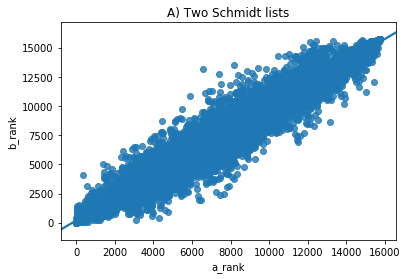

In [8]:
sns.regplot(df['a_rank'], df['b_rank']).set_title("A) Two Schmidt lists")

Text(0.5, 1.0, 'B) Gandal BD vs SCZ')

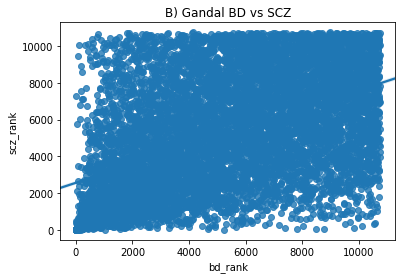

In [9]:
sns.regplot(df['bd_rank'], df['scz_rank']).set_title("B) Gandal BD vs SCZ")